# <b>Introduction:</b>
It is required to design a hand-written numeral recognition system that being trained using given data. Features should be extracted from that data using different methods, train the model with different algorithms and then test the model and compare between these methods accuraces.

## Features generation:
 - Centroid features.
 - AutoEncoder.

## Classification algorithms:
 - k-means clustering.
 - GMM.
 - SVM.


In [49]:
#Initializing needed libaries
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as plt
from scipy.fftpack import dct as dct
from scipy import io as spio
from scipy import ndimage as img
from random import randint
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import time
from sklearn.metrics import confusion_matrix
from scipy import linalg as la
from numpy.linalg import inv
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
from scipy.ndimage.measurements import center_of_mass
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# <font color='navy' size=4><b>Core Functions:</b></font>
### -Extract Data
<p>This function handles the input data, first it reads the input features and labels, then it reshapes features into an image pixels format while labeles transform it into class number instead of hot one.</p>

### -Standarize
<p>To make data in standard form with mean=0 and variance of 1, this function takes the input data and standarize them.</p>
<p> The standarization process decreases the the values of input data making information dense in smaller values while keeping all information, due to smaller values computational process becomes faster which is in favour of the algorithm.</p> 

### -Unroll
<p>Unrolling of input into a single vector for other functions.</p>

### -dct_2D
<p>DCT is a powerful transformation for features which decreases number of features dramatically while keeping most of information and variations in data.</p>
<p> first 2D DCT transformation is applied on the data then Zigzag reading of DCT coefficient to make the most of the transformation. </p>

### -pca_fit & pca_trans
<p>PCA is another powerful transformation where it reduces input features into smaller number of feature, it reduces the number of dimensions of the input data while keeping high variations of the data.</p>
<p> pca_fit forms the model on the training data, while pca_trans transforms the test features into the same model of the training data.</p>

### -KMeans
<p>K-Means is one of the most known clusrting algorithms, in order to use it with our classification problem it was applied on each class training data in order to produce the means of the each class data, then at test time nearest class is assigned to the input vector with the nearest distance from cluster of the assigned class.</p>

### -GMM
<p>Guassian Mixture Model is another important algorithm of clustering, it takes longer time for training however it helps a lot in increasing accuracy when compared to kmeans using same number of clusters</p>

### -predict_acc
<p>In this function it estimates which class should be assigned to the test example, and then calculates the accuracy of the predictions according to the true labels.</p>

### -accuracy 
<p>In this function it calculates the correctly predicted classes ratio to the whole test set and returns the accuracy.</p>

### -find_class
<p>This function estimates the class that should be assigned to the currrebt test vector of features, this function is uded by predict_acc</p>

### -Centroids
<p> Slicing the input image into 9 slices that have the same size and returns an array containing these slices.</p>

### -Get_Centroid_Features
<p> Taking these slices that (centroids) function returns, and then compute the distance between the center of mass of each slice and center of mass of the image and finally returns these distances as the desired features.</p>

### -features_diagonalization
<p> We can diagonalize the covariance matrix of the new features using this function that returns a diagonal matrix containing eignvalues of the features.</p>


In [50]:
#Functions definations 
#extract data from Mat format and normalize the image
def extract(Data):
    features=[]
    output=[]
    for i in range (Data.shape[0]):
            features.append(Data[i,0])
            output.append(Data[i,1])
    features=np.array(features)
    output=np.array(output)
    features=np.reshape(features,[features.shape[0]*features.shape[1],28,28])/1.0
    output=np.reshape(output,[output.shape[0]*output.shape[1],output.shape[2]])
    output=[np.where(r==1)[0][0] for r in output]
    return features, np.array(output)
def standarize(x):
    stnd=[]
    for i in range(x.shape[0]):
        scaler = StandardScaler()
        scaler.fit(x[i]) 
        temp=scaler.transform(x[i])
        stnd.append(temp)
    return np.array(stnd)
def unroll(a):
    a=a.reshape(a.shape[0],a.shape[1]*a.shape[2])
    return a
#2D dct
def dct_2D(x):
    a=[]
    for i in range (x.shape[0]):
        x_dct=dct(dct(x[i],norm='ortho').T,norm='ortho').T;
        a.append([x_dct[0,0], x_dct[0,1], x_dct[1,0], x_dct[2,0], x_dct[1,1],\
                  x_dct[0,2], x_dct[0,3], x_dct[1,2], x_dct[2,1], x_dct[3,0],\
                  x_dct[4,0], x_dct[3,1], x_dct[2,2], x_dct[1,3], x_dct[0,4],\
                  x_dct[0,5], x_dct[1,4], x_dct[2,3], x_dct[3,2], x_dct[4,1]])   
    return np.array(a)
#PCA
def pca_fit(x,n):
    #x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n)
    pca.fit(x)
    pca_comp=pca.transform(x)
    var=sum(pca.explained_variance_ratio_)*100
    return pca_comp,var,pca
def pca_trans(x,pca):
    #x = StandardScaler().fit_transform(x)
    pca_comp=pca.transform(x)
    var=sum(pca.explained_variance_ratio_)*100.0
    return pca_comp,var
#K-Means
def kmeans(clusters,classes_n,Features_Train,class_margin):
    kmeans_=[]
    for i in range (classes_n):  
        kmeans_temp=KMeans(n_clusters=clusters,n_init=10,max_iter=5000,algorithm='full',random_state=0).\
        fit(Features_Train[i*class_margin:i*class_margin+class_margin-1])
        kmeans_.append(kmeans_temp.cluster_centers_)
    kmeans_=np.array(kmeans_)
    return kmeans_
#GMM 
def GMM(Mixtures,classes_n,Features_Train,class_margin):
    G=[]
    for i in range (classes_n):  
        G_temp=GaussianMixture(n_components=Mixtures,n_init=10,max_iter=5000,covariance_type='full',random_state=0).\
        fit(Features_Train[i*class_margin:i*class_margin+class_margin-1])
        G.append(G_temp.means_)
    G=np.array(G)
    return G
#Predict
def predict_acc(test_features,label_set,model):
    Y_predict=np.zeros_like(label_set)
    for i in range (Y_predict.shape[0]):
        Y_predict[i]=find_class(test_features[i],model)
    acc1=accuracy(label_set,Y_predict)
    return acc1,Y_predict
#accuracy calc 
def accuracy(original,predicted):
    acc=original-predicted
    acc[acc != 0] = 1
    acc=(np.count_nonzero(acc == 0)*1.0/original.shape[0])*100.0
    return acc
#class decision
def find_class(x,y):
    min_d=np.ones(y.shape[0])*100000000.0
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            temp=np.linalg.norm(x-y[i][j])
            if temp<min_d[i]:
                min_d[i]=temp
    min_class_idx=np.argmin(min_d)
    return min_class_idx
#Grid slicing
def Centroids(x):
    Slice_1=[]
    Slice_2=[]
    Slice_3=[]
    Slice_4=[]
    Slice_5=[]
    Slice_6=[]
    Slice_7=[]
    Slice_8=[]
    
    for i in range (x.shape[0]):
        Slice_1.append(np.hstack(x[i][0:9,0:9]))
        Slice_2.append(np.hstack(x[i][0:9,9:18]))
        Slice_3.append(np.hstack(x[i][0:9,18:27]))
        
        Slice_4.append(np.hstack(x[i][9:18,0:9]))
        Slice_5.append(np.hstack(x[i][9:18,18:27]))
        
        Slice_6.append(np.hstack(x[i][18:27,0:9]))
        Slice_7.append(np.hstack(x[i][18:27,9:18]))
        Slice_8.append(np.hstack(x[i][18:27,18:27]))
    
    Slices = { "S1": np.array(Slice_1).reshape(x.shape[0],9,9),
               "S2": np.array(Slice_2).reshape(x.shape[0],9,9),
               "S3": np.array(Slice_3).reshape(x.shape[0],9,9),
               "S4": np.array(Slice_4).reshape(x.shape[0],9,9),
               "S5": np.array(Slice_5).reshape(x.shape[0],9,9),
               "S6": np.array(Slice_6).reshape(x.shape[0],9,9),
               "S7": np.array(Slice_7).reshape(x.shape[0],9,9),
               "S8": np.array(Slice_8).reshape(x.shape[0],9,9)
             }
    return Slices
def Get_Centroid_Features(x_slices, x_train):
    Features=[]
    for i in range (x_train.shape[0]):
        stack=[]
        for j in range (1,9):
            a=np.array(center_of_mass(x_slices["S"+str(j)][i])).reshape(1,2)
            b=np.array(center_of_mass(x_train[i])).reshape(1,2)
            
            if math.isnan(a[0,0]):
                a=np.zeros((1,2))
            
            stack.append(np.linalg.norm(a-b))
        k=np.array(stack)
        o=k.reshape(1,8)
        Features.append(o)
    return np.array(Features).reshape((x_train.shape[0],8))
#feature diagnolization
def features_diagonalization(x):
    m = x.shape[1]
    covariance_matrix = (1/m) * np.dot(np.transpose(x),x)
    # covariance_matrix.shape
    e_vals, e_vecs = la.eig(covariance_matrix)
    diagonal_eignvalues = np.dot(np.dot(inv(e_vecs),covariance_matrix),e_vecs)
    return diagonal_eignvalues

## <font color='navy'><b>Step 1:</b></font>
* Read Data
* Extract the features and labels
* Standarize the features
* Unroll the Features
* Show an example of handwritten image

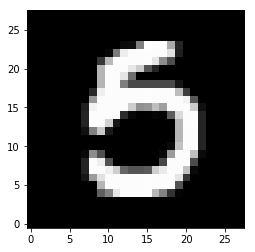

Label = 5 image = 5782


In [69]:
#Read Data
R_MNIST=spio.loadmat('./ReducedMNIST.mat')
R_MINST_Train=R_MNIST['SmallTrainData']
R_MINST_Test=R_MNIST['SmallTestData']
#extract features and labels
X_Train,Y_Train= extract(R_MINST_Train)
X_Train_std=standarize(X_Train)
X_Test,Y_Test= extract(R_MINST_Test)
X_Test_std=standarize(X_Test)
#unroll images
X_Train_unroll=unroll(X_Train_std)
X_Train_unroll_norm=unroll(X_Train)/255.0
X_Test_unroll=unroll(X_Test_std)
X_Test_unroll_norm=unroll(X_Test)/255.0
#show a random picture example
img_num=randint(0,X_Train.shape[0])
plt.pyplot.imshow(img.rotate(X_Train[img_num],90),origin='lower')
plt.pyplot.gray()
plt.pyplot.show()
print("Label = "+ str(Y_Train[img_num])+" image = "+ str(img_num))

## <font color='navy'><b>Step 2:</b></font>
Extracting the centroid features from training and test data by calling (Centroids) and (Get_Centroid_Features) functions.

In [52]:
#extracting centeroids features for Train and Test Data
Slices_Train=Centroids(X_Train)
Centroid_Features_Train= Get_Centroid_Features(Slices_Train,X_Train)
Slices_Test=Centroids(X_Test)
Centroid_Features_Test= Get_Centroid_Features(Slices_Test, X_Test)

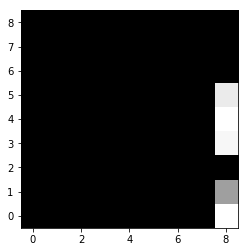

In [53]:
#plot a slice example
img_num=randint(0,X_Train.shape[0])
plt.pyplot.imshow(img.rotate(Slices_Train["S2"][img_num],90),origin='lower')
plt.pyplot.gray()
plt.pyplot.show()

## <font color='navy'><b>Step 3:</b></font>
Creating Autoencoder model that extracts 10 features and training it using the given data.


## Autoencoding:
"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent.

One reason why they have attracted so much research and attention is because they have long been thought to be a potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels. Then again, autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here. At this point there is significant evidence that focusing on the reconstruction of a picture at the pixel level, for instance, is not conductive to learning interesting, abstract features of the kind that label-supervized learning induces (where targets are fairly abstract concepts "invented" by humans such as "dog", "car"...). In fact, one may argue that the best features in this regard are those that are the worst at exact input reconstruction while achieving high performance on the main task that you are interested in (classification, localization, etc).

In [55]:
encoding_dim = 10  #size of output of encoder 
Compression_ratio=784/encoding_dim
input_img = Input(shape=(784,)) #input placeholder
encoded = Dense(encoding_dim, activation='relu')(input_img) #encoding layer output
decoded = Dense(784, activation='sigmoid')(encoded) #decoding layer output
autoencoder = Model(input_img, decoded) #autoencoder model
encoder = Model(input_img, encoded) #encoder model
encoded_input = Input(shape=(encoding_dim,)) #input placeholder for decoder input
decoder_layer = autoencoder.layers[-1] # retrieve the last layer of the autoencoder model
decoder = Model(encoded_input, decoder_layer(encoded_input)) #decoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')#compile autoencoder mode
print(round(Compression_ratio,3))
print("Compression ratio =" , round(Compression_ratio,4))

78.4
Compression ratio = 78.4


In [56]:
#Train the Autoencoder 
autoencoder.fit(X_Train_unroll_norm, X_Train_unroll_norm,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(X_Test_unroll_norm, X_Test_unroll_norm))

Train on 10000 samples, validate on 1000 samples
Epoch 1/70
10000/10000 [==============================] - 2s 224us/step - loss: 0.5927 - val_loss: 0.3894
Epoch 2/70
10000/10000 [==============================] - 2s 177us/step - loss: 0.3180 - val_loss: 0.2868
Epoch 3/70
10000/10000 [==============================] - 2s 159us/step - loss: 0.2826 - val_loss: 0.2762
Epoch 4/70
10000/10000 [==============================] - 2s 174us/step - loss: 0.2737 - val_loss: 0.2678
Epoch 5/70
10000/10000 [==============================] - 2s 204us/step - loss: 0.2646 - val_loss: 0.2571
Epoch 6/70
10000/10000 [==============================] - 2s 181us/step - loss: 0.2532 - val_loss: 0.2448
Epoch 7/70
10000/10000 [==============================] - 2s 178us/step - loss: 0.2415 - val_loss: 0.2333
Epoch 8/70
10000/10000 [==============================] - 2s 203us/step - loss: 0.2309 - val_loss: 0.2237
Epoch 9/70
10000/10000 [==============================] - 2s 206us/step - loss: 0.2219 - val_loss: 0.21

In [57]:
#encode and decode Test Images
encoded_imgs = encoder.predict(X_Test_unroll_norm)
decoded_imgs = decoder.predict(encoded_imgs)

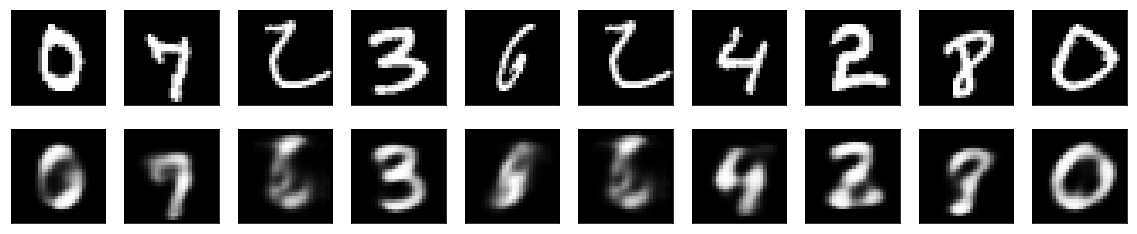

In [11]:
#display Original test images and decoded Images examples
n = 10  # how many digits we will display
plt.pyplot.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.pyplot.subplot(2, n, i + 1)
    img_num=randint(0,X_Test.shape[0])
    plt.pyplot.imshow(img.rotate(X_Test[img_num].reshape(28, 28),90),origin='lower')
    plt.pyplot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.pyplot.subplot(2, n, i + 1 + n)
    plt.pyplot.imshow(img.rotate(decoded_imgs[img_num].reshape(28, 28),90),origin='lower')
    plt.pyplot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.pyplot.show()

In [58]:
#Create Encoded data for train and test datasets
encoded_Train = encoder.predict(X_Train_unroll_norm)
encoded_Test = encoder.predict(X_Test_unroll_norm)

## <font color='navy'><b>Step 4:</b></font>
Using output features from the Autoencoder (10 features), train the model using K-means clustering algorithm with different number of clusters and comparing output accuracy when classifing test images.

In [13]:
#KMeans 1 cluster AutoEncoder
tic = time.time()
kmeans_encode1=kmeans(1,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.2005 sec


In [14]:
#Encoder KMeans 1 cluster Prediction 
tic = time.time()
acc_kmeans_encoded1,Y_encoded_KMeans1=predict_acc(encoded_Test,Y_Test,kmeans_encode1)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans1 = pd.crosstab(Y_Test, Y_encoded_KMeans1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans1)

accuracy = 68.5 %
elapsed time = 0.2063 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,79,4,1,0,1,12,0,0,3,0,100
1,0,90,1,0,0,0,0,0,9,0,100
2,2,6,74,2,1,0,5,2,8,0,100
3,1,8,2,71,0,7,0,2,8,1,100
4,0,4,0,0,64,2,1,0,1,28,100
5,6,15,1,7,1,40,5,0,17,8,100
6,3,7,2,0,2,3,83,0,0,0,100
7,0,10,1,1,4,1,0,67,5,11,100
8,3,4,3,8,1,9,0,0,63,9,100


In [15]:
#KMeans 2 cluster AutoEncoder
tic = time.time()
kmeans_encode2=kmeans(2,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.5895 sec


In [16]:
#Encoder KMeans 2 cluster Prediction 
tic = time.time()
acc_kmeans_encoded2,Y_encoded_KMeans2=predict_acc(encoded_Test,Y_Test,kmeans_encode2)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans2 = pd.crosstab(Y_Test, Y_encoded_KMeans2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans2)

accuracy = 69.5 %
elapsed time = 0.3687 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,81,0,1,0,0,17,0,0,1,0,100
1,0,92,1,2,0,0,0,0,5,0,100
2,1,2,73,3,2,1,8,2,8,0,100
3,1,2,3,75,1,6,0,3,9,0,100
4,0,3,0,0,55,7,2,0,1,32,100
5,8,6,5,7,1,50,5,1,12,5,100
6,9,2,5,0,3,3,77,0,1,0,100
7,0,8,4,0,2,1,0,69,3,13,100
8,2,2,0,7,2,13,2,0,61,11,100


In [60]:
#KMeans 4 cluster AutoEncoder
tic = time.time()
kmeans_encode4=kmeans(4,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.9261 sec


In [64]:
#Encoder KMeans 4 cluster Prediction 
tic = time.time()
acc_kmeans_encoded4,Y_encoded_KMeans4=predict_acc(encoded_Test,Y_Test,kmeans_encode4)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(5):
    print("\n")
print("Confusion Matrix:")
confusion_encoded_KMeans4 = pd.crosstab(Y_Test, Y_encoded_KMeans4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans4)

accuracy = 77.5 %
elapsed time = 0.7188 sec











Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,82,0,0,1,0,11,3,0,3,0,100
1,0,98,0,0,0,0,1,0,1,0,100
2,2,2,76,4,1,1,2,3,9,0,100
3,0,1,4,79,0,5,0,1,7,3,100
4,0,1,0,1,71,4,5,1,3,14,100
5,7,0,1,4,3,59,4,0,14,8,100
6,6,0,5,0,3,2,83,0,1,0,100
7,0,7,2,0,1,1,0,80,1,8,100
8,1,0,2,6,2,6,1,0,69,13,100


In [65]:
#KMeans 8 cluster AutoEncoder
tic = time.time()
kmeans_encode8=kmeans(8,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.3526 sec


In [66]:
#Encoder KMeans 8 cluster Prediction 
tic = time.time()
acc_kmeans_encoded8,Y_encoded_KMeans8=predict_acc(encoded_Test,Y_Test,kmeans_encode8)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded8,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(7):
    print("\n")
print("Confusion Matrix:")
confusion_encoded_KMeans8 = pd.crosstab(Y_Test, Y_encoded_KMeans8,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans8)

accuracy = 81.8 %
elapsed time = 1.2506 sec















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,86,0,0,0,0,11,2,0,1,0,100
1,0,99,0,0,0,0,1,0,0,0,100
2,3,2,83,2,1,0,2,2,5,0,100
3,1,1,5,79,0,2,0,3,8,1,100
4,0,2,1,2,74,1,4,0,0,16,100
5,4,1,1,3,3,72,4,0,10,2,100
6,5,0,2,0,3,0,89,0,1,0,100
7,0,5,0,0,1,1,0,81,1,11,100
8,1,0,0,4,2,10,0,0,75,8,100


In [21]:
#KMeans 16 cluster AutoEncoder
tic = time.time()
kmeans_encode16=kmeans(16,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.9621 sec


In [22]:
#Encoder KMeans 16 cluster Prediction 
tic = time.time()
acc_kmeans_encoded16,Y_encoded_KMeans16=predict_acc(encoded_Test,Y_Test,kmeans_encode16)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded16,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans16 = pd.crosstab(Y_Test, Y_encoded_KMeans16,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans16)

accuracy = 81.8 %
elapsed time = 2.6752 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,89,0,0,0,0,9,2,0,0,0,100
1,0,99,0,0,0,0,1,0,0,0,100
2,3,3,81,1,1,1,2,2,4,2,100
3,0,2,2,82,0,4,0,2,6,2,100
4,0,1,1,1,78,2,2,0,0,15,100
5,2,0,0,3,1,75,3,1,11,4,100
6,2,0,1,0,3,1,91,0,2,0,100
7,0,4,1,0,1,0,0,83,3,8,100
8,2,2,2,8,4,7,0,1,69,5,100


## <font color='navy'><b>Step 5:</b></font>
Using the same features from autoencoder, but with GMM algorithm with different number of GMM.

In [23]:
#encoded GMM 1
tic = time.time()
G_encoded1=GMM(1,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.8652 sec


In [24]:
#encoded GMM 1 Predictions
tic = time.time()
acc_GMM_encoded1,Y_encoded_GMM1=predict_acc(encoded_Test,Y_Test,G_encoded1)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
print("\nConfusion Matrix:")
confusion_encoded_GMM1 = pd.crosstab(Y_Test, Y_encoded_GMM1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM1)

accuracy = 68.5 %
elapsed time = 0.1993 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,79,4,1,0,1,12,0,0,3,0,100
1,0,90,1,0,0,0,0,0,9,0,100
2,2,6,74,2,1,0,5,2,8,0,100
3,1,8,2,71,0,7,0,2,8,1,100
4,0,4,0,0,64,2,1,0,1,28,100
5,6,15,1,7,1,40,5,0,17,8,100
6,3,7,2,0,2,3,83,0,0,0,100
7,0,10,1,1,4,1,0,67,5,11,100
8,3,4,3,8,1,9,0,0,63,9,100


In [67]:
#encoded GMM 2
tic = time.time()
G_encoded2=GMM(2,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 2.8205 sec


In [68]:
#encoded GMM 2 Predictions
tic = time.time()
acc_GMM_encoded2,Y_encoded_GMM2=predict_acc(encoded_Test,Y_Test,G_encoded2)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
for t in range(9):
    print("\n")
print("\nConfusion Matrix:")
confusion_encoded_GMM2 = pd.crosstab(Y_Test, Y_encoded_GMM2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM2)

accuracy = 71.0 %
elapsed time = 0.3324 sec



















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,77,0,2,0,1,15,1,0,4,0,100
1,0,90,0,0,0,0,0,0,10,0,100
2,3,4,71,2,2,3,4,2,9,0,100
3,2,6,4,69,0,4,0,2,13,0,100
4,1,4,0,0,63,7,3,0,0,22,100
5,10,1,0,9,3,49,7,0,15,6,100
6,4,2,1,1,6,8,78,0,0,0,100
7,0,9,0,0,3,1,0,73,3,11,100
8,3,2,3,4,3,7,1,0,67,10,100


In [27]:
#encoded GMM 4
tic = time.time()
G_encoded4=GMM(4,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 9.8912 sec


In [28]:
#encoded GMM 4 Predictions
tic = time.time()
acc_GMM_encoded4,Y_encoded_GMM4=predict_acc(encoded_Test,Y_Test,G_encoded4)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
print("\nConfusion Matrix:")
confusion_encoded_GMM4 = pd.crosstab(Y_Test, Y_encoded_GMM4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM4)

accuracy = 73.8 %
elapsed time = 0.6614 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,82,1,2,0,1,13,1,0,0,0,100
1,1,95,0,3,0,0,0,0,1,0,100
2,5,3,73,3,3,1,4,2,6,0,100
3,3,5,2,75,1,3,0,2,8,1,100
4,0,4,2,0,65,1,3,0,1,24,100
5,15,1,2,8,1,60,3,0,6,4,100
6,6,2,3,0,3,3,82,0,1,0,100
7,0,8,0,0,3,1,0,70,3,15,100
8,5,2,1,8,2,10,1,0,64,7,100


## <font color='navy'><b>Step 6:</b></font>
Same autoencoder 10 features with SVM algorithm with linear and nonlinear kernals.

In [70]:
#encoded Linear SVM
tic = time.time()
svm_encoded_lin = svm.SVC(kernel='linear')
svm_encoded_lin.fit(encoded_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 3.8738 sec


In [71]:
#encoded Linear SVM Prediction
tic = time.time()
acc_encoded_svm=accuracy_score(Y_Test,svm_encoded_lin.predict(encoded_Test))*100
toc = time.time()
print('accuracy = ',round(acc_encoded_svm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
for t in range(4):
    print("\n")
print("\nConfusion Matrix:")
confusion_svm_encoded_lin = pd.crosstab(Y_Test, svm_encoded_lin.predict(encoded_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_encoded_lin)

accuracy =  82.7 %
elapsed time = 0.0676 sec









Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,90,0,0,0,0,8,1,0,1,0,100
1,0,91,2,2,0,1,0,0,4,0,100
2,1,1,81,0,2,1,8,2,4,0,100
3,2,0,3,84,0,4,0,1,5,1,100
4,0,1,0,1,87,0,3,0,0,8,100
5,7,0,3,5,4,71,3,1,5,1,100
6,0,1,6,0,1,1,90,0,1,0,100
7,0,1,3,1,0,2,0,83,3,7,100
8,4,0,5,7,3,3,0,2,74,2,100


In [72]:
#encoded non-Linear SVM
tic = time.time()
svm_encoded_nlin = svm.SVC(kernel='rbf')
svm_encoded_nlin.fit(encoded_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 9.9671 sec


In [73]:
#encoded non-Linear SVM Prediction
tic = time.time()
acc_encoded_nsvm=accuracy_score(Y_Test,svm_encoded_nlin.predict(encoded_Test))*100
toc = time.time()
print('accuracy = ',round(acc_encoded_nsvm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
for t in range(6):
    print("\n")
print("\nConfusion Matrix:")
confusion_svm_encoded_nlin = pd.crosstab(Y_Test,svm_encoded_nlin.predict(encoded_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_encoded_nlin)

accuracy =  77.5 %
elapsed time = 0.3825 sec













Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,89,0,10,0,0,1,0,0,0,0,100
1,0,89,9,1,0,0,0,0,0,1,100
2,2,0,96,1,0,0,0,1,0,0,100
3,0,0,17,78,0,1,0,1,3,0,100
4,0,0,17,0,74,1,1,0,0,7,100
5,8,0,28,2,0,61,1,0,0,0,100
6,4,0,21,0,2,0,73,0,0,0,100
7,0,0,22,0,0,0,0,71,1,6,100
8,1,0,28,2,0,2,0,0,62,5,100


## <font color='navy'><b>Step 7:</b></font>
Creating autoencoder model that gives 20 features instead of 10 and training it using training data.

In [74]:
K.clear_session()#clear old model

In [75]:
encoding_dim = 20  #size of output of encoder 
Compression_ratio=784/encoding_dim
input_img = Input(shape=(784,)) #input placeholder
encoded = Dense(encoding_dim, activation='relu')(input_img) #encoding layer output
decoded = Dense(784, activation='sigmoid')(encoded) #decoding layer output
autoencoder = Model(input_img, decoded) #autoencoder model
encoder = Model(input_img, encoded) #encoder model
encoded_input = Input(shape=(encoding_dim,)) #input placeholder for decoder input
decoder_layer = autoencoder.layers[-1] # retrieve the last layer of the autoencoder model
decoder = Model(encoded_input, decoder_layer(encoded_input)) #decoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')#compile autoencoder mode
print("Compression ratio =" , round(Compression_ratio,3))

Compression ratio = 39.2


In [76]:
# Train the Autoencoder 
autoencoder.fit(X_Train_unroll_norm, X_Train_unroll_norm,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(X_Test_unroll_norm, X_Test_unroll_norm))

Train on 10000 samples, validate on 1000 samples
Epoch 1/70
10000/10000 [==============================] - 2s 193us/step - loss: 0.5432 - val_loss: 0.3245
Epoch 2/70
10000/10000 [==============================] - 2s 197us/step - loss: 0.2912 - val_loss: 0.2742
Epoch 3/70
10000/10000 [==============================] - 2s 165us/step - loss: 0.2666 - val_loss: 0.2545
Epoch 4/70
10000/10000 [==============================] - 2s 189us/step - loss: 0.2461 - val_loss: 0.2353
Epoch 5/70
10000/10000 [==============================] - 2s 178us/step - loss: 0.2288 - val_loss: 0.2204
Epoch 6/70
10000/10000 [==============================] - 1s 147us/step - loss: 0.2155 - val_loss: 0.2087
Epoch 7/70
10000/10000 [==============================] - 2s 189us/step - loss: 0.2051 - val_loss: 0.1995
Epoch 8/70
10000/10000 [==============================] - 2s 186us/step - loss: 0.1967 - val_loss: 0.1921
Epoch 9/70
10000/10000 [==============================] - 2s 224us/step - loss: 0.1899 - val_loss: 0.18

In [77]:
#encode and decode Test Images
encoded_imgs = encoder.predict(X_Test_unroll_norm)
decoded_imgs = decoder.predict(encoded_imgs)

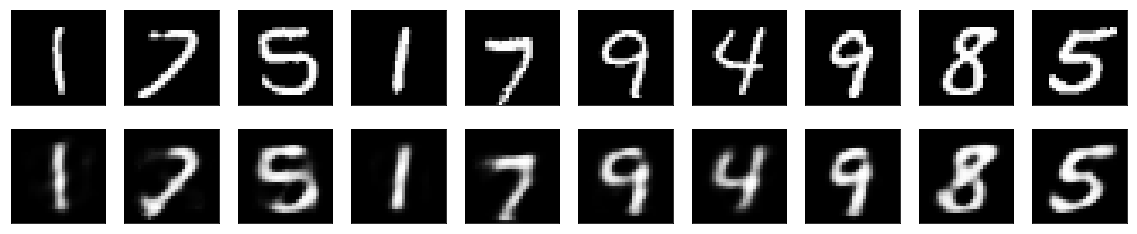

In [37]:
#display Original test images and decoded Images examples
n = 10  # how many digits we will display
plt.pyplot.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.pyplot.subplot(2, n, i + 1)
    img_num=randint(0,X_Test.shape[0])
    plt.pyplot.imshow(img.rotate(X_Test[img_num].reshape(28, 28),90),origin='lower')
    plt.pyplot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.pyplot.subplot(2, n, i + 1 + n)
    plt.pyplot.imshow(img.rotate(decoded_imgs[img_num].reshape(28, 28),90),origin='lower')
    plt.pyplot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.pyplot.show()

In [20]:
#Create Encoded data for train and test datasets
encoded_Train = encoder.predict(X_Train_unroll_norm)
encoded_Test = encoder.predict(X_Test_unroll_norm)

## <font color='navy'><b>Step 8:</b></font>
Autoencoder 20 features - K-means clustering algorithm

In [39]:
#KMeans 1 cluster AutoEncoder
tic = time.time()
kmeans_encode1=kmeans(1,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.2773 sec


In [40]:
#Encoder KMeans 1 cluster Prediction 
tic = time.time()
acc_kmeans_encoded1,Y_encoded_KMeans1=predict_acc(encoded_Test,Y_Test,kmeans_encode1)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans1 = pd.crosstab(Y_Test, Y_encoded_KMeans1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans1)

accuracy = 70.8 %
elapsed time = 0.2781 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,76,3,1,0,2,14,1,0,3,0,100
1,0,91,1,0,0,1,0,0,7,0,100
2,2,6,72,2,2,1,5,2,8,0,100
3,1,3,3,64,1,18,3,2,4,1,100
4,1,7,0,1,73,1,1,0,4,12,100
5,2,14,0,12,1,44,9,0,16,2,100
6,6,10,2,0,0,2,80,0,0,0,100
7,1,10,1,0,1,0,0,70,6,11,100
8,3,7,2,9,1,5,0,0,70,3,100


In [41]:
#KMeans 2 cluster AutoEncoder
tic = time.time()
kmeans_encode2=kmeans(2,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.7324 sec


In [42]:
#Encoder KMeans 2 cluster Prediction 
tic = time.time()
acc_kmeans_encoded2,Y_encoded_KMeans2=predict_acc(encoded_Test,Y_Test,kmeans_encode2)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans2 = pd.crosstab(Y_Test, Y_encoded_KMeans2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans2)

accuracy = 74.9 %
elapsed time = 0.4994 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,82,0,3,2,0,8,2,0,3,0,100
1,0,91,1,0,0,1,2,0,5,0,100
2,1,3,72,2,3,1,6,2,10,0,100
3,1,1,3,79,0,4,2,2,8,0,100
4,0,3,0,0,65,4,2,0,1,25,100
5,3,0,0,12,4,67,7,0,3,4,100
6,4,0,4,1,2,3,86,0,0,0,100
7,0,7,1,0,3,3,0,74,3,9,100
8,3,0,2,8,2,8,0,1,65,11,100


In [43]:
#KMeans 4 cluster AutoEncoder
tic = time.time()
kmeans_encode4=kmeans(4,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.1783 sec


In [44]:
#Encoder KMeans 4 cluster Prediction 
tic = time.time()
acc_kmeans_encoded4,Y_encoded_KMeans4=predict_acc(encoded_Test,Y_Test,kmeans_encode4)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_encoded_KMeans4 = pd.crosstab(Y_Test, Y_encoded_KMeans4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans4)

accuracy = 79.2 %
elapsed time = 0.7612 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,89,0,0,2,0,5,2,0,2,0,100
1,0,94,1,0,0,0,1,0,4,0,100
2,2,1,78,4,3,0,3,2,7,0,100
3,0,1,3,83,0,3,1,1,7,1,100
4,0,4,1,0,69,0,2,2,2,20,100
5,4,2,1,6,1,66,7,0,9,4,100
6,3,0,8,0,2,2,83,0,2,0,100
7,0,5,1,1,0,0,0,76,3,14,100
8,2,0,0,5,2,6,1,1,77,6,100


In [78]:
#KMeans 8 cluster AutoEncoder
tic = time.time()
kmeans_encode8=kmeans(8,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 3.0829 sec


In [79]:
#Encoder KMeans 8 cluster Prediction 
tic = time.time()
acc_kmeans_encoded8,Y_encoded_KMeans8=predict_acc(encoded_Test,Y_Test,kmeans_encode8)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded8,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(3):
    print("\n")
print("Confusion Matrix:")
confusion_encoded_KMeans8 = pd.crosstab(Y_Test, Y_encoded_KMeans8,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans8)

accuracy = 81.8 %
elapsed time = 1.21 sec







Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,86,0,0,0,0,11,2,0,1,0,100
1,0,99,0,0,0,0,1,0,0,0,100
2,3,2,83,2,1,0,2,2,5,0,100
3,1,1,5,79,0,2,0,3,8,1,100
4,0,2,1,2,74,1,4,0,0,16,100
5,4,1,1,3,3,72,4,0,10,2,100
6,5,0,2,0,3,0,89,0,1,0,100
7,0,5,0,0,1,1,0,81,1,11,100
8,1,0,0,4,2,10,0,0,75,8,100


In [80]:
#KMeans 16 cluster AutoEncoder
tic = time.time()
kmeans_encode16=kmeans(16,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.9765 sec


In [81]:
#Encoder KMeans 16 cluster Prediction 
tic = time.time()
acc_kmeans_encoded16,Y_encoded_KMeans16=predict_acc(encoded_Test,Y_Test,kmeans_encode16)
toc = time.time()
print("accuracy =",round(acc_kmeans_encoded16,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(9):
    print("\n")
print("Confusion Matrix:")
confusion_encoded_KMeans16 = pd.crosstab(Y_Test, Y_encoded_KMeans16,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_KMeans16)

accuracy = 82.7 %
elapsed time = 2.1724 sec



















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,85,0,0,0,0,11,4,0,0,0,100
1,0,99,0,0,0,0,1,0,0,0,100
2,2,3,79,3,1,1,1,2,6,2,100
3,0,3,2,83,1,3,0,1,6,1,100
4,0,1,1,0,83,2,3,0,0,10,100
5,4,0,0,2,2,75,3,0,10,4,100
6,1,1,1,0,1,2,94,0,0,0,100
7,0,2,0,0,1,0,0,82,2,13,100
8,2,0,3,7,3,5,1,0,72,7,100


## <font color='navy'><b>Step 9:</b></font>
Autoencoder 20 features - GMM algorithm

In [49]:
#encoded GMM 1
tic = time.time()
G_encoded1=GMM(1,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.5118 sec


In [50]:
#encoded GMM 1 Predictions
tic = time.time()
acc_GMM_encoded1,Y_encoded_GMM1=predict_acc(encoded_Test,Y_Test,G_encoded1)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
print("\nConfusion Matrix:")
confusion_encoded_GMM1 = pd.crosstab(Y_Test, Y_encoded_GMM1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM1)

accuracy = 70.8 %
elapsed time = 0.2528 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,76,3,1,0,2,14,1,0,3,0,100
1,0,91,1,0,0,1,0,0,7,0,100
2,2,6,72,2,2,1,5,2,8,0,100
3,1,3,3,64,1,18,3,2,4,1,100
4,1,7,0,1,73,1,1,0,4,12,100
5,2,14,0,12,1,44,9,0,16,2,100
6,6,10,2,0,0,2,80,0,0,0,100
7,1,10,1,0,1,0,0,70,6,11,100
8,3,7,2,9,1,5,0,0,70,3,100


In [51]:
#encoded GMM 2
tic = time.time()
G_encoded2=GMM(2,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 5.0127 sec


In [52]:
#encoded GMM 2 Predictions
tic = time.time()
acc_GMM_encoded2,Y_encoded_GMM2=predict_acc(encoded_Test,Y_Test,G_encoded2)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
print("\nConfusion Matrix:")
confusion_encoded_GMM2 = pd.crosstab(Y_Test, Y_encoded_GMM2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM2)

accuracy = 74.5 %
elapsed time = 0.622 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,79,1,2,1,1,13,0,0,2,1,100
1,0,92,1,0,0,0,1,0,6,0,100
2,4,4,75,0,2,2,2,2,9,0,100
3,0,4,3,72,3,3,0,1,14,0,100
4,1,3,0,0,67,4,2,0,1,22,100
5,3,5,0,6,1,62,8,0,12,3,100
6,3,7,3,1,3,1,82,0,0,0,100
7,0,8,0,1,5,1,0,70,5,10,100
8,2,1,2,6,3,7,0,0,76,3,100


In [82]:
#encoded GMM 4
tic = time.time()
G_encoded4=GMM(4,10,encoded_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 5.7405 sec


In [83]:
#encoded GMM 4 Predictions
tic = time.time()
acc_GMM_encoded4,Y_encoded_GMM4=predict_acc(encoded_Test,Y_Test,G_encoded4)
toc = time.time()
print("accuracy =",round(acc_GMM_encoded4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
for t in range(10):
    print("\n")
print("\nConfusion Matrix:")
confusion_encoded_GMM4 = pd.crosstab(Y_Test, Y_encoded_GMM4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_encoded_GMM4)

accuracy = 75.2 %
elapsed time = 0.7746 sec





















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,79,0,1,0,0,16,2,0,2,0,100
1,0,94,0,0,0,0,1,0,5,0,100
2,3,3,76,1,2,2,4,2,7,0,100
3,0,1,3,71,2,10,0,3,9,1,100
4,1,2,1,0,66,6,2,0,2,20,100
5,4,0,0,6,5,64,6,0,8,7,100
6,4,0,5,0,4,4,83,0,0,0,100
7,0,5,3,0,2,3,0,74,2,11,100
8,2,2,3,3,2,6,0,1,70,11,100


## <font color='navy'><b>Step 10:</b></font>
Autoencoder 20 features - SVM algorithm

In [55]:
#encoded Linear SVM
tic = time.time()
svm_encoded_lin = svm.SVC(kernel='linear')
svm_encoded_lin.fit(encoded_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 6.7535 sec


In [56]:
#encoded Linear SVM Prediction
tic = time.time()
acc_encoded_svm=accuracy_score(Y_Test,svm_encoded_lin.predict(encoded_Test))*100
toc = time.time()
print('accuracy = ',round(acc_encoded_svm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
print("\nConfusion Matrix:")
confusion_svm_encoded_lin = pd.crosstab(Y_Test, svm_encoded_lin.predict(encoded_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_encoded_lin)

accuracy =  88.4 %
elapsed time = 0.0661 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,95,0,1,0,0,4,0,0,0,0,100
1,0,92,1,0,0,1,1,1,4,0,100
2,1,3,82,0,2,1,5,2,3,1,100
3,0,0,1,90,0,5,0,1,3,0,100
4,0,1,2,0,89,1,1,0,0,6,100
5,1,1,3,3,1,86,1,0,4,0,100
6,0,0,3,0,0,2,95,0,0,0,100
7,0,0,0,2,3,0,0,90,1,4,100
8,0,0,4,4,0,7,2,3,78,2,100


In [21]:
#encoded non-Linear SVM
tic = time.time()
svm_encoded_nlin = svm.SVC(kernel='rbf')
svm_encoded_nlin.fit(encoded_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 21.9054 sec


In [22]:
#encoded non-Linear SVM Prediction
tic = time.time()
acc_encoded_nsvm=accuracy_score(Y_Test,svm_encoded_nlin.predict(encoded_Test))*100
toc = time.time()
print('accuracy = ',round(acc_encoded_nsvm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
print("\nConfusion Matrix:")
confusion_svm_encoded_nlin = pd.crosstab(Y_Test,svm_encoded_nlin.predict(encoded_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_encoded_nlin)

accuracy =  65.9 %
elapsed time = 0.5429 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,72,0,28,0,0,0,0,0,0,0,100
1,0,86,13,0,0,0,0,0,0,1,100
2,0,0,100,0,0,0,0,0,0,0,100
3,0,0,33,66,0,0,0,1,0,0,100
4,0,0,39,0,57,0,0,0,0,4,100
5,0,0,56,1,0,43,0,0,0,0,100
6,0,0,38,0,0,0,62,0,0,0,100
7,0,0,40,0,0,0,0,57,0,3,100
8,0,0,50,0,0,0,0,0,49,1,100


## <font color='navy'><b>Step 11:</b></font>
centroid features - KMeans clustering classifing algorithm

In [84]:
#KMeans 1 cluster centroid features
tic = time.time()
kmeans_centroid1=kmeans(1,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.1766 sec


In [85]:
#centroid features KMeans 1 cluster Prediction 
tic = time.time()
acc_kmeans_centroid1,Y_centroid_KMeans1=predict_acc(Centroid_Features_Test,Y_Test,kmeans_centroid1)
toc = time.time()
print("accuracy =",round(acc_kmeans_centroid1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(2):
    print("\n")
print("Confusion Matrix:")
confusion_centroid_KMeans1 = pd.crosstab(Y_Test, Y_centroid_KMeans1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_KMeans1)

accuracy = 39.1 %
elapsed time = 0.1646 sec





Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,61,4,16,11,1,6,0,1,0,0,100
1,2,97,0,1,0,0,0,0,0,0,100
2,37,7,20,17,0,6,1,12,0,0,100
3,10,21,12,31,0,11,0,15,0,0,100
4,11,5,2,0,30,5,10,27,0,10,100
5,18,10,1,21,4,33,4,5,2,2,100
6,24,19,15,2,0,0,31,7,1,1,100
7,0,10,2,10,1,7,3,54,0,13,100
8,13,29,0,15,3,6,1,26,0,7,100


In [86]:
#KMeans 2 cluster centroid features
tic = time.time()
kmeans_centroid2=kmeans(2,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.2772 sec


In [87]:
#centroid features KMeans 2 cluster Prediction 
tic = time.time()
acc_kmeans_centroid2,Y_centroid_KMeans2=predict_acc(Centroid_Features_Test,Y_Test,kmeans_centroid2)
toc = time.time()
print("accuracy =",round(acc_kmeans_centroid2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(9):
    print("\n")
print("Confusion Matrix:")
confusion_centroid_KMeans2 = pd.crosstab(Y_Test, Y_centroid_KMeans2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_KMeans2)

accuracy = 47.4 %
elapsed time = 0.2732 sec



















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,94,1,1,0,1,0,3,0,0,0,100
1,2,95,0,1,0,0,2,0,0,0,100
2,28,7,40,9,0,2,2,8,0,4,100
3,26,7,5,43,0,2,2,10,0,5,100
4,16,2,4,0,50,1,9,0,0,18,100
5,38,9,5,9,6,22,7,1,0,3,100
6,27,0,11,0,7,0,50,0,0,5,100
7,4,11,1,9,12,2,1,39,2,19,100
8,19,24,3,6,10,5,6,13,1,13,100


In [63]:
#KMeans 4 cluster centroid features
tic = time.time()
kmeans_centroid4=kmeans(4,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.4591 sec


In [64]:
#centroid features KMeans 4 cluster Prediction 
tic = time.time()
acc_kmeans_centroid4,Y_centroid_KMeans4=predict_acc(Centroid_Features_Test,Y_Test,kmeans_centroid4)
toc = time.time()
print("accuracy =",round(acc_kmeans_centroid4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
print("Confusion Matrix:")
confusion_centroid_KMeans4 = pd.crosstab(Y_Test, Y_centroid_KMeans4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_KMeans4)

accuracy = 56.4 %
elapsed time = 0.5595 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,82,0,4,6,4,2,2,0,0,0,100
1,0,95,1,0,0,0,2,0,0,2,100
2,10,0,49,17,6,1,6,6,5,0,100
3,8,0,14,46,1,3,7,10,6,5,100
4,7,2,2,4,45,7,7,0,4,22,100
5,18,7,0,11,6,36,3,8,9,2,100
6,16,0,1,1,2,0,78,0,0,2,100
7,3,2,1,11,6,1,1,53,7,15,100
8,8,1,2,9,13,3,2,27,25,10,100


In [88]:
#KMeans 8 cluster centroid features
tic = time.time()
kmeans_centroid8=kmeans(8,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.6708 sec


In [89]:
#centroid features KMeans 8 cluster Prediction 
tic = time.time()
acc_kmeans_centroid8,Y_centroid_KMeans8=predict_acc(Centroid_Features_Test,Y_Test,kmeans_centroid8)
toc = time.time()
print("accuracy =",round(acc_kmeans_centroid8,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(2):
    print("\n")
print("Confusion Matrix:")
confusion_centroid_KMeans8 = pd.crosstab(Y_Test, Y_centroid_KMeans8,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_KMeans8)

accuracy = 64.0 %
elapsed time = 0.8203 sec





Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,78,1,1,7,1,5,3,1,2,1,100
1,0,97,0,0,0,0,1,0,0,2,100
2,9,0,55,10,2,0,6,0,15,3,100
3,4,0,6,59,3,12,2,7,5,2,100
4,6,2,3,1,53,8,7,2,2,16,100
5,12,0,0,8,5,54,3,5,10,3,100
6,19,1,1,0,2,1,74,1,1,0,100
7,1,1,4,13,3,1,2,59,5,11,100
8,7,1,3,4,0,11,0,13,58,3,100


In [90]:
#KMeans 16 cluster centroid features
tic = time.time()
kmeans_centroid16=kmeans(16,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.2157 sec


In [91]:
#centroid features KMeans 16 cluster Prediction 
tic = time.time()
acc_kmeans_centroid16,Y_centroid_KMeans16=predict_acc(Centroid_Features_Test,Y_Test,kmeans_centroid16)
toc = time.time()
print("accuracy =",round(acc_kmeans_centroid16,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec\n")
for t in range(7):
    print("\n")
print("Confusion Matrix:")
confusion_centroid_KMeans16 = pd.crosstab(Y_Test, Y_centroid_KMeans16,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_KMeans16)

accuracy = 70.5 %
elapsed time = 1.6371 sec















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,83,0,1,7,0,4,1,1,2,1,100
1,0,92,1,0,0,0,4,0,1,2,100
2,5,0,68,3,1,2,5,0,13,3,100
3,7,0,4,57,0,13,2,6,10,1,100
4,4,2,2,0,65,6,4,3,2,12,100
5,14,0,1,5,3,63,3,2,9,0,100
6,7,0,1,0,3,2,85,0,2,0,100
7,0,0,3,3,5,1,1,67,8,12,100
8,8,1,5,7,1,9,0,10,55,4,100


## <font color='navy'><b>Step 12:</b></font>
centroid features - GMM classifing algorithm

In [92]:
#centroid features GMM 1
tic = time.time()
G_centroid1=GMM(1,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.306 sec


In [94]:
#Centroid Features GMM 1 Predictions
tic = time.time()
acc_GMM_centroid1,Y_centroid_GMM1=predict_acc(Centroid_Features_Test,Y_Test,G_centroid1)
toc = time.time()
print("accuracy =",round(acc_GMM_centroid1,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
print("\nConfusion Matrix:")
confusion_centroid_GMM1 = pd.crosstab(Y_Test, Y_centroid_GMM1,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_GMM1)

accuracy = 39.1 %
elapsed time = 0.1784 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,61,4,16,11,1,6,0,1,0,0,100
1,2,97,0,1,0,0,0,0,0,0,100
2,37,7,20,17,0,6,1,12,0,0,100
3,10,21,12,31,0,11,0,15,0,0,100
4,11,5,2,0,30,5,10,27,0,10,100
5,18,10,1,21,4,33,4,5,2,2,100
6,24,19,15,2,0,0,31,7,1,1,100
7,0,10,2,10,1,7,3,54,0,13,100
8,13,29,0,15,3,6,1,26,0,7,100


In [95]:
#centroid features GMM 2
tic = time.time()
G_centroid2=GMM(2,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 0.5598 sec


In [96]:
#Centroid Features GMM 2 Predictions
tic = time.time()
acc_GMM_centroid2,Y_centroid_GMM2=predict_acc(Centroid_Features_Test,Y_Test,G_centroid2)
toc = time.time()
print("accuracy =",round(acc_GMM_centroid2,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
for t in range(3):
    print("\n")
print("\nConfusion Matrix:")
confusion_centroid_GMM2 = pd.crosstab(Y_Test, Y_centroid_GMM2,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_GMM2)

accuracy = 45.8 %
elapsed time = 0.2467 sec







Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,94,4,1,0,1,0,0,0,0,0,100
1,2,96,0,1,0,0,1,0,0,0,100
2,28,7,40,9,0,2,2,8,0,4,100
3,24,10,2,42,0,2,5,10,0,5,100
4,16,5,4,0,49,1,10,0,0,15,100
5,38,13,6,8,6,22,3,1,0,3,100
6,31,19,5,0,1,0,40,1,0,3,100
7,4,11,1,9,10,3,5,39,2,16,100
8,19,30,3,5,10,5,1,13,1,13,100


In [97]:
#centroid features GMM 4
tic = time.time()
G_centroid4=GMM(4,10,Centroid_Features_Train,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 2.1262 sec


In [98]:
#Centroid Features GMM 4 Predictions
tic = time.time()
acc_GMM_centroid4,Y_centroid_GMM4=predict_acc(Centroid_Features_Test,Y_Test,G_centroid4)
toc = time.time()
print("accuracy =",round(acc_GMM_centroid4,2),"%") 
print("elapsed time =",round(toc-tic,4),"sec")
for t in range(8):
    print("\n")
print("\nConfusion Matrix:")
confusion_centroid_GMM4 = pd.crosstab(Y_Test, Y_centroid_GMM4,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_centroid_GMM4)

accuracy = 53.4 %
elapsed time = 0.5312 sec

















Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,78,0,4,9,3,2,1,0,3,0,100
1,0,95,1,0,0,0,2,0,2,0,100
2,7,1,50,15,6,0,3,11,6,1,100
3,6,0,12,46,2,4,7,12,5,6,100
4,8,1,2,3,45,7,6,0,5,23,100
5,13,1,0,9,7,33,3,10,14,10,100
6,28,0,1,2,4,0,63,0,0,2,100
7,4,3,1,11,7,0,1,53,6,14,100
8,7,4,3,8,13,4,0,27,25,9,100


## <font color='navy'><b>Step 13:</b></font>
centroid features - SVM classifing algorithm

In [75]:
#centroid feature Linear SVM
tic = time.time()
svm_centroid_lin = svm.SVC(kernel='linear')
svm_centroid_lin.fit(Centroid_Features_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 4.788 sec


In [76]:
#centroid feature Linear SVM Prediction
tic = time.time()
acc_centroid_svm=accuracy_score(Y_Test,svm_centroid_lin.predict(Centroid_Features_Test))*100
toc = time.time()
print('accuracy = ',round(acc_centroid_svm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
print("\nConfusion Matrix:")
confusion_svm_centroid_lin = pd.crosstab(Y_Test, svm_centroid_lin.predict(Centroid_Features_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_centroid_lin)

accuracy =  62.0 %
elapsed time = 0.1362 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,84,0,3,4,0,4,2,1,2,0,100
1,0,95,0,0,0,0,2,0,1,2,100
2,9,1,73,0,1,1,8,1,6,0,100
3,8,0,2,49,4,18,3,7,9,0,100
4,7,1,4,3,53,1,4,3,3,21,100
5,18,0,2,15,9,31,6,5,11,3,100
6,6,0,1,2,2,1,88,0,0,0,100
7,0,2,6,7,11,4,1,45,9,15,100
8,7,2,3,4,11,9,3,13,42,6,100


In [77]:
#centroid feature non-Linear SVM
tic = time.time()
svm_centroid_nlin = svm.SVC(kernel='rbf')
svm_centroid_nlin.fit(Centroid_Features_Train,Y_Train)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec") 

elapsed time = 2.6397 sec


In [78]:
#centroid non-Linear SVM Prediction
tic = time.time()
acc_centroid_nsvm=accuracy_score(Y_Test,svm_centroid_nlin.predict(Centroid_Features_Test))*100
toc = time.time()
print('accuracy = ',round(acc_centroid_nsvm,2),"%")
print("elapsed time =",round(toc-tic,4),"sec") 
print("\nConfusion Matrix:")
confusion_svm_centroid_nlin = pd.crosstab(Y_Test,svm_centroid_nlin.predict(Centroid_Features_Test),\
                                    rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_svm_centroid_nlin)

accuracy =  81.1 %
elapsed time = 0.2521 sec

Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,93,0,1,1,0,1,1,0,3,0,100
1,1,95,0,0,0,0,2,1,0,1,100
2,2,0,86,3,1,0,2,0,5,1,100
3,2,0,2,75,1,11,1,2,6,0,100
4,2,2,1,0,76,0,2,0,0,17,100
5,11,0,0,5,3,72,3,0,6,0,100
6,3,0,1,0,1,2,92,0,1,0,100
7,0,0,1,2,3,1,0,73,5,15,100
8,4,1,3,6,1,6,0,7,69,3,100


In [99]:
X_Train_conc=np.concatenate((encoded_Train,Centroid_Features_Train),axis=1)
X_Test_conc=np.concatenate((encoded_Test,Centroid_Features_Test),axis=1)

In [102]:
#concatenated K-Means
tic = time.time()
kmeans_conc=kmeans(16,10,X_Train_conc,1000)
toc = time.time()
print("elapsed time =",round(toc-tic,4),"sec")

elapsed time = 1.637 sec


In [104]:
#concatenated kmeans Predictions
tic = time.time()
acc_kmeans_conc,Y_conc=predict_acc(X_Test_conc,Y_Test,kmeans_conc)
toc = time.time()
print("accuracy =",round(acc_kmeans_conc,2),"%")
print("elapsed time =",round(toc-tic,4),"sec")
for t in range(3):
    print("\n")
print("\nConfusion Matrix:")
confusion_kmeans_conc = pd.crosstab(Y_Test,Y_conc,rownames=['Actual'], colnames=['Predicted'], margins=True)
display(confusion_kmeans_conc)

accuracy = 81.9 %
elapsed time = 1.6228 sec







Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,90,0,0,1,0,7,2,0,0,0,100
1,0,98,1,0,0,0,1,0,0,0,100
2,2,0,82,3,0,1,2,2,8,0,100
3,0,2,5,77,0,7,0,3,5,1,100
4,0,2,3,0,79,1,1,0,1,13,100
5,5,1,1,8,2,70,4,1,7,1,100
6,2,0,1,0,1,1,93,0,1,1,100
7,0,1,1,0,1,0,0,85,2,10,100
8,0,0,3,8,3,9,0,0,67,10,100


Aftar that, PCA analysis is used to diagonalize the covariance of the new feature using the formule (S=U^-1 * sigma* U)
sigma : covariance matrix of the PCA output 
U is the matrix of Eigenvectors 
S is a diagonal matrix containing the Eigenvalues

In [48]:
# Concatenated feature matrix can be passed to (features_diagonalization) function and the diagonalized covariance of the new
# features is returned
import pandas as pd
from pandas import DataFrame

diagonalized_covariance = features_diagonalization(X_Train_conc)
df= pd.DataFrame(diagonalized_covariance)
display(df)

,0,1,2,3,...,24,25,26,27
0,1.241785e+06,-2.910383e-11,1.136868e-10,-2.364686e-11,...,-1.591616e-11,-2.091838e-10,6.912160e-11,-8.731149e-11
1,6.048140e-11,3.985821e+04,1.509193e-11,1.145395e-11,...,-4.021672e-12,-1.276135e-11,1.458034e-11,-5.968559e-12
2,1.656559e-10,8.753887e-12,1.854361e+04,4.391154e-12,...,5.029532e-12,6.690648e-12,-6.410872e-12,-1.532996e-11
3,-5.860556e-11,-6.528467e-11,8.943957e-12,1.656175e+04,...,2.507328e-12,-3.213430e-12,-3.829825e-12,-2.451372e-12
...,...,...,...,...,...,...,...,...,...
24,-1.672085e-11,-2.004263e-11,-3.134271e-12,2.534306e-12,...,2.968486e+03,-6.057377e-13,-2.813916e-12,1.686873e-12
25,-8.793322e-11,-3.424816e-12,-1.432410e-12,-3.299583e-12,...,4.329592e-12,3.429456e+03,-4.877876e-12,7.256418e-13
26,1.234568e-11,3.099743e-12,5.562883e-12,1.261213e-13,...,5.062617e-14,-2.643219e-12,3.286509e+03,-9.974244e-13
27,3.525713e-11,-5.385914e-12,9.485746e-13,2.763123e-12,...,4.023448e-13,-3.780087e-12,2.018830e-12,3.154725e+03


* The highest values are across the digonal of the matrix.

# <font color=navy>Comparison of Models</font>
* <font size=3>Different Models can be compared with each other according to accuracy,time of training and time of prediction as shown in the following table:</font>
    
|        Model type      |    Features generation |   Time of training   |  Time of prediction  |  Accuracy  |
|------------------------|------------------------|----------------------|----------------------| -----------------
|  K-means 1 cluster     |Autoencoder 10 features |       0.2149 sec     |       0.2204 sec     |    68.1 %
|                        |Autoencoder 20 features |       0.243 sec      |       0.2417 sec     |    73.5 %
|                        |   Centroid features    |       0.1048 sec     |       0.1505 sec     |    39.1 %
|                        |           dct          |      0.1867 sec      |       0.203 sec      |    59.0 %
|                        |           pca          |      0.2049 sec      |       0.4456 sec     |    74.6 %
|  K-means 2 cluster     |Autoencoder 10 features |       0.6302 sec     |       0.4122 sec     |    72.4 %
|                        |Autoencoder 20 features |       0.6786 sec     |       0.4124 sec     |    78.1 %
|                        |   Centroid features    |       0.211 sec      |       0.2994 sec     |    47.4 %
|                        |           dct          |       0.7688 sec     |       0.2694 sec     |    63.8 %
|                        |           pca          |      0.9964 sec      |       0.2717 sec     |    80.0 %
|  K-means 4 cluster     |Autoencoder 10 features |       1.1509 sec     |       0.7499 sec     |    77.7 %
|                        |Autoencoder 20 features |       1.669 sec      |       0.8415 sec     |    80.8 %
|                        |   Centroid features    |       0.4457 sec     |       0.5447 sec     |    56.4 %
|                        |           dct          |       1.7464 sec     |       0.5254 sec     |    70.3 %
|                        |           pca          |       2.0397 sec     |       0.4357 sec     |    83.6 %
|  K-means 8 cluster     |Autoencoder 10 features |       1.3082 sec     |       1.4513 sec     |    79.3 %
|                        |Autoencoder 20 features |       1.7365 sec     |       1.522 sec      |    85.4 %
|                        |   Centroid features    |       0.7509 sec     |       1.0431 sec     |    64.0 %
|                        |           dct          |        1.7679 sec    |       0.8271 sec     |    75.0 %
|                        |           pca          |       2.3743 sec     |       0.8552 sec     |    89.6 %
|  K-means 16 cluster    |Autoencoder 10 features |       1.9183 sec     |       2.7627 sec     |    80.4 %
|                        |Autoencoder 20 features |       1.8665 sec     |       2.804 sec      |    88.1 %
|                        |   Centroid features    |       1.5426 sec     |       1.976 sec      |    70.5 %
|   | Concatenating centroid and encoder features |       1.9795 sec     |       1.7749 sec     |    82.0 %
|                        |          dct           |       2.2373 sec     |       1.6846 sec     |    78.2 %
|                        |          pca           |        2.6695 sec    |       1.8107 sec     |    91.7 %
|   | Concatenated dct and pca  features          |        3.395 sec     |       1.6362 sec     |    91.2 %
|        1 GMM           |Autoencoder 10 features |       0.7902 sec     |       0.2434 sec     |    70.1 %
|                        |Autoencoder 20 features |       0.5094 sec     |       0.2465 sec     |    73.5 %
|                        |   Centroid features    |       0.3852 sec     |       0.1796 sec     |    39.1 %
|                        |          dct           |       0.4935 sec     |       0.1967 sec     |    59.0 %
|                        |          pca           |       0.8466 sec     |       0.1948 sec     |    74.6 %
|        2 GMM           |Autoencoder 10 features |       3.0359 sec     |       0.3434 sec     |    69.6 %
|                        |Autoencoder 20 features |       3.5069 sec     |       0.373 sec      |    76.2 %
|                        |   Centroid features    |       0.7093 sec     |       0.3169 sec     |    45.8 %
|                        |          dct           |       1.8323 sec     |       0.2372 sec     |    65.1 %
|                        |          pca           |        6.0392 sec    |       0.279 sec      |    79.9 %
|        4 GMM           |Autoencoder 10 features |       8.2123 sec     |       0.7396 sec     |    76.2 %
|                        |Autoencoder 20 features |       9.5174 sec     |       0.7264 sec     |    77.9 %
|                        |   Centroid features    |       1.8107 sec     |       0.4924 sec     |    53.4 %
|                        |          dct           |        5.58 sec      |       0.6094 sec     |    70.9 %
|                        |          pca           |        7.2452 sec    |       0.4895 sec     |    83.3 %
|  SVM - linear kernals  |Autoencoder 10 features |       4.4774 sec     |       0.0679 sec     |    82.7 %
|                        |Autoencoder 20 features |       5.7885 sec     |       0.0626 sec     |    89.1 %
|                        |   Centroid features    |       4.4105 sec     |       0.193 sec      |    62.0 %
|                        |          dct           |        2.2755 sec    |       0.1475 sec     |    82.0 %
|                        |          pca           |        4.4507 sec    |       0.2876 sec     |    90.3 %
|SVM - non linear kernals|Autoencoder 10 features |       10.2875 sec    |       0.3847 sec     |    77.0 %
|                        |Autoencoder 20 features |       11.4055 sec    |       0.5152 sec     |    68.7 %
|                        |   Centroid features    |       2.4326 sec     |       0.265 sec      |    81.1 %
|                        |          dct           |        2.5146 sec    |       0.0797 sec     |    92.1 %
|                        |          pca           |      5.3565 sec      |       0.5247 sec     |    97.3 %

## <font color=navy>Conclusion:</font>
<p>Classification of Handwriiten numbers is an important part of day to day services and industries, using machines can increase efficiency of this process, descision of which algorithm to use depends on accuracy of this algorithm and processing time of it in our problem next points were noticed:</p>
* As the number of clusters increases the accuracy increases.
* As the number of clusters increases computational time increases.
* GMM gives better accuracy for the same number of clusters over the KMeans, with more computational time in dct and pca features.
* Concatenation of the PCA and DCT didn't increase the accuracy dramatically, it almost remained the same as using PCA only.
* Centroid features was the worst among the feature reduction algorithms in most clustering algorithms however it did a better job with non linear svm than autoencoder.
* Using Autoencoder has the upper hand regarding its accuracy since it tailors the output features on the type of the input it was trained on.
* As the number of output nodes in the encoder increases accuracy increases.
* Autoencoder has relatively slower timing due to time it takes to be trained on dataset rather than being a ready mathematical transformation.
* Non linear classification can hurt the algorithm rather than benefit from it.
* SVM with non-linear kernel was the most powerful algorithm of classification among the algorithms for this problem regarding accuracy using pca features.
* Autoencoder can benefit from deeping the layers but that will cause the model to be computationally to be more expensive in terms of time and memory usage.
* As the number of epochs loops increases loss function decreases and gets slower as learning algorithm reaches the minimum point.